In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import gamma

%matplotlib inline

# Discounted integral 'Voting'

Simple model proposed for implementing and testing a voting scheme

- Assume a dynamic supply of governance tokens accessed by a bonding ETH (linear bonding curve)
- Assume this tokens also represent a stake in a revenue generating process
- The revenue generating process is has one parameter which is "governed" 
- The revenue generated is random and there is a true "best parameter" unknown to the voters which may change
- The goal of the 'voting' system is for the selected parameter to trend toward the "best parameter" (even if it changes)
- In this set up, voting is completely passive, "votes" are automatically determined by each agents belief state and counted according to their balance of the 'Tokens' that representing their voting capacity
- An agent has the right to change their belief or preference at any time but the effect of their prior beliefs or prefences continues to influence the system, decaying in time according to the forgetfulness parameter
- These tokens also represent their stake in the pool of Ether being generated by the revenue process

This is a sensor fusion problem -- coordination problem. The environment, the pool of agents, the process, the actions and the system updates have been made mind-numbingly noisy in order to show the effect of the di

In [2]:
#Define the Revenue generating process
def revenue(true_best_param,current_voted_param ):
    #use an concave function with unique maximum as true_best_param = current_voted_param
    base_scale = 1
    scale = base_scale*np.exp(-(true_best_param-current_voted_param)**2)
    shape = .5
    return gamma(scale, shape).rvs()

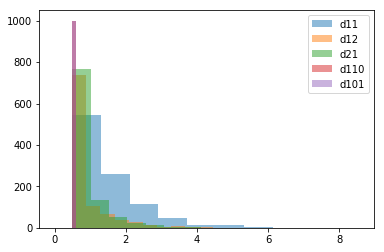

In [3]:
#test the revenue random variable as a function of how right the param is
N = 1000
bins = 10
d11=np.zeros(N)
d12=np.zeros(N)
d21=np.zeros(N)
d110=np.zeros(N)
d101=np.zeros(N)
for i in range(N):
    d11[i] = revenue(1,1)
    d12[i] = revenue(1,2)
    d21[i] = revenue(2,1)
    d110[i] = revenue(1,10)
    d101[i] = revenue(10,1)

plt.hist(d11, bins, alpha=0.5, label='d11')
plt.hist(d12, bins, alpha=0.5, label='d12')
plt.hist(d21, bins, alpha=0.5, label='d21')
plt.hist(d110, bins, alpha=0.5, label='d110')
plt.hist(d101, bins, alpha=0.5, label='d101')

plt.legend(loc='upper right')
plt.show()

In [4]:
#Lets assuming that all tokens in existence is given by T

def bond_mint(eth, Eth, Tokens):
    return eth*Tokens/Eth

def burn_withdraw(tokens, Eth, Tokens):
    return tokens*Eth/Tokens


In [5]:
#define a set of agents
agents = {}

#in this passive voting model agents maintain a belief or a preference as part of their state with respect
#to the contract the 'token' came from
#their belief or preference may be updated by them at will
def add_agent(eth, tbparam, Eth, Tokens):
    agents[str(len(agents))] = {"eth":eth,
                           "tokens":0,
                           "param_belief": 2*tbparam*np.random.uniform(),
                           "value_belief":2*Tokens/Eth*np.random.uniform()}
    

def agent_acts(a, Eth, Tokens, r, p):
    #update value belief
    agents[a]["value_belief"] = 2*Tokens/Eth*np.random.uniform()
    
    #update tokens held -- buy or sell -- pretty naive with random belief and random amount
    if agents[a]["value_belief"]<Tokens/Eth:
        urv =np.random.uniform() 
        burn = agents[a]["tokens"]*urv
        eth_out = burn_withdraw(burn, Eth, Tokens)
        
        agents[a]["tokens"] = agents[a]["tokens"]-burn
        agents[a]["eth"] = agents[a]["eth"] + eth_out
        Tokens = Tokens - burn
        Eth = Eth - eth_out
        
    else:
        
        urv =np.random.uniform() 
        bond =agents[a]["eth"]*urv
        mint = bond_mint(bond, Eth, Tokens)
        
        agents[a]["tokens"] = agents[a]["tokens"]+mint
        agents[a]["eth"] = agents[a]["eth"] -bond
        Tokens = Tokens + mint
        Eth = Eth + bond
        
    #update believe by taking a tiny step along slope of observations
    #only assumption is that the agent roughly estimates the direction of better returns from observed revenue events
    agents[a]["param_belief"] = np.max([0,agents[a]["param_belief"] + np.random.uniform()*np.polyfit(p, r, 1)[0]])

    #print(agents[a]["value_belief"])
    return Eth, Tokens, agents[a]




In [6]:
K= 50000
alpha=.95 #forgetfulness
true_best_param = 5*np.ones(K) 
#throw a step change in there to mix things up
#true_best_param[:int(K/2)] =.5*true_best_param[:int(K/2)]


E=np.zeros(K)
T=np.zeros(K)

A=np.zeros(K)

Eth =1
Tokens =100
E[0] = Eth
T[0] = Tokens
A[0] = 1

agents = {}
add_agent(gamma(5,1).rvs(), true_best_param[0], Eth, Tokens)

votes=np.zeros(K)
count=np.zeros(K)
param=np.zeros(K)
rev=np.zeros(K)

n = np.zeros(K)
n[0]=1

for k in range(1,K):
    Eth = E[k-1]
    Tokens = T[k-1]
    #resolve governance -- what is the belief of the param
    votes[k] = (np.sum([agents[a]["tokens"]*agents[a]["param_belief"] for a in list(agents.keys())])+ alpha*votes[k-1])
    count[k] = (np.sum([agents[a]["tokens"] for a in list(agents.keys())])+ alpha*count[k-1])
    if count[k]>0:
        param[k] = votes[k]/count[k]
    else:
        param[k] = 1
    rev[k] = revenue(true_best_param[k],param[k])
    Eth = Eth+rev[k]
    
    #new agents join
    if np.random.uniform()< np.log10(K/k):
        new = int(2*np.random.uniform())
        for i in range(new):
            add_agent(gamma(5,1).rvs(), true_best_param[k], Eth, Tokens)
    n[k]=len(agents)
        
    #pick some to update on the order of log of agents
    active = random.sample(list(agents.keys()), int(np.log2(len(agents))))
    for a in active:
        Eth, Tokens, val = agent_acts(a, Eth, Tokens, rev[:k+1], param[:k+1])
        agents[a] = val
    
    A[k] = len(active)
    E[k] = Eth
    T[k] = Tokens
    

In [7]:
k

49999

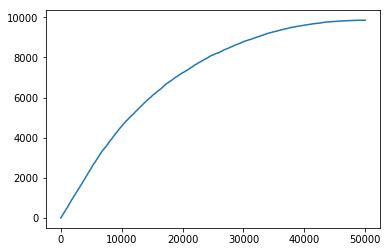

In [8]:
plt.plot(range(K),n)

(array([2.9647e+04, 1.4560e+04, 4.0430e+03, 1.1820e+03, 3.9800e+02,
        1.0900e+02, 3.8000e+01, 1.4000e+01, 6.0000e+00, 3.0000e+00]),
 array([ 0.        ,  1.10725381,  2.21450762,  3.32176142,  4.42901523,
         5.53626904,  6.64352285,  7.75077666,  8.85803046,  9.96528427,
        11.07253808]),
 <a list of 10 Patch objects>)

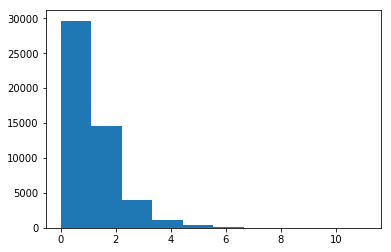

In [9]:
plt.hist(rev)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.04513681e-05, 0.00000000e+00, 0.00000000e+00, 1.60902736e-04,
        5.09008724e-04, 1.28404393e-02, 9.21238778e-02, 5.70530723e-01,
        2.71035714e+00, 6.61315611e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.41354104e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
        -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
        -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
        -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.0000

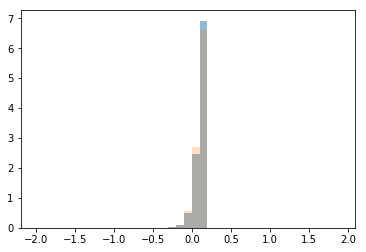

In [37]:
plt.hist((true_best_param-param)/true_best_param, bins=(np.arange(-1,1,.1)), density=True, alpha=.5)
plt.hist((true_best_param-param)/true_best_param, bins=(np.arange(-1,1,.1)), density=True, weights = rev, alpha=.25)

Text(0.5,0,'Number of Agents')

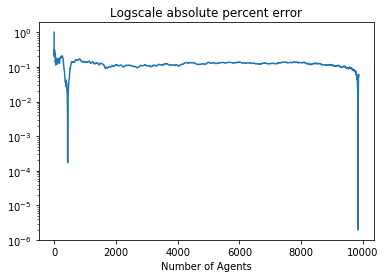

In [27]:
plt.semilogy(n, np.abs(true_best_param - param)/true_best_param, n, .1)
plt.title("Logscale absolute percent error")
plt.labels(["error", "10% reference"])
plt.xlabel("Number of Agents")

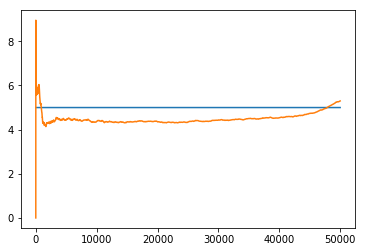

In [21]:
plt.plot(range(K), true_best_param, range(K), param )

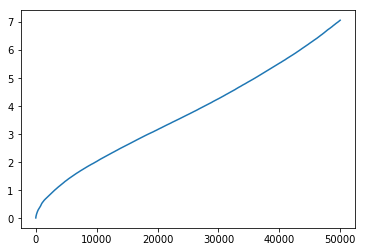

In [12]:
plt.plot(range(K), E/T)

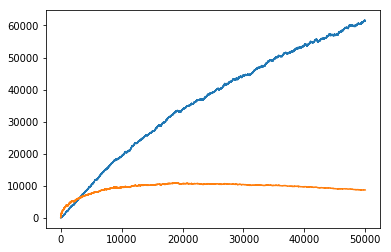

In [13]:
plt.plot(range(K), E, range(K), T)

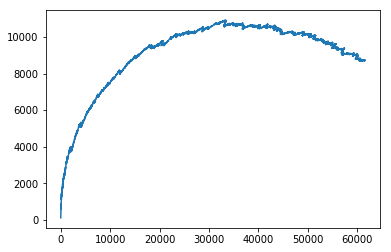

In [14]:
plt.plot(E, T)

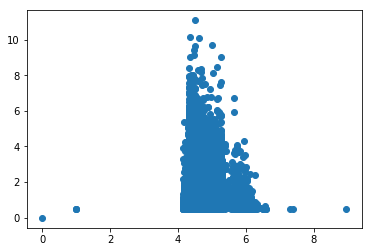

In [15]:
plt.scatter(param,rev)

[4, 6, 0, 4]

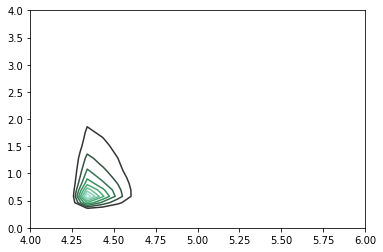

In [16]:
sns.kdeplot(param,rev)
plt.axis([4,6,0,4])

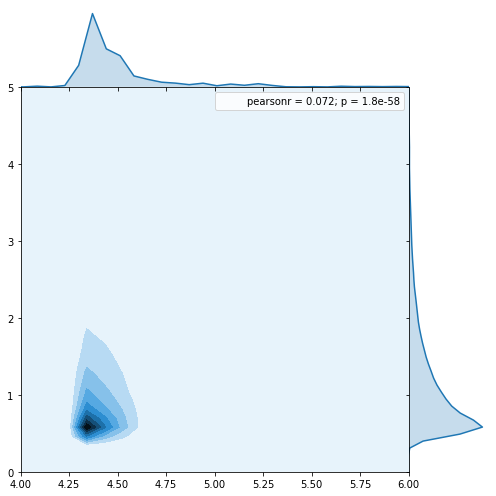

In [17]:
sns.jointplot(param, rev, kind="kde", size=7, space=0, xlim=[4,6],ylim=[0,5])